In [1]:
from abc import ABC, abstractmethod
import random
import copy
import math
import numpy as np
from heapq import nsmallest

import matplotlib as mpl
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.use('pgf')
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)

mpl.rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Base Classes

In [2]:
class Individual(ABC):
    def __init__(self, genes = None, numberOfGenes = None, error = None):
        self.__error = None
        self.genes = genes if genes else [self.getRandomGene() for i in range(numberOfGenes)]
        self.setError(error)
        
    def setError(self, error):
        self.__error = error
    
    def getError(self):
        return self.__error
    
    @abstractmethod
    def clone(self):
        """Should return a new instance with the same properties"""
        pass
    
    @staticmethod
    def createFromMutation(individual, probability):
        clone = individual.clone()
        genes = []
        for gene in clone.genes:
            gene = type(individual).mutateGene(gene, probability)
            genes += [gene]
        
        clone.genes = genes
        clone.values = clone.calculateFloatValues()
        return clone
    
    @staticmethod
    def createFromTwoPointCrossOver(a, b):
        if not len(a.genes) == len(b.genes):
            raise ArgumentException('For crossover, gene length must be the same!')
        
        clone = a.clone()
        genes = []
        for geneIndex in range(len(a.genes)):
            gene1 = copy.deepcopy(a.genes[geneIndex])
            gene2 = copy.deepcopy(b.genes[geneIndex])
            gene = type(a).twoPointCrossOverGenes(gene1, gene2)
            genes += [gene]
        
        clone.genes = genes
        clone.values = clone.calculateFloatValues()
        return clone
    
    @abstractmethod
    def getRandomGene(self):
        pass
    
    @staticmethod
    @abstractmethod
    def mutateGene(gene, probability):
        """Should mutate the alleles in the gene and return a new gene"""
        pass
    
    @staticmethod
    @abstractmethod
    def twoPointCrossOverGenes(a, b):
        """Should crossover the alleles in the gene and return a new gene"""
        pass

In [3]:
class BitstringIndividual(Individual):
    def __init__(self, interval, genes = None, numberOfGenes = None, error = None):
        super().__init__(genes, numberOfGenes, error)
        self.interval = interval
        self.values = self.calculateFloatValues()
    
    def getRandomGene(self):
        return [random.choice([True, False]) for i in range(16)]

    def clone(self):
        return BitstringIndividual(
            genes = copy.deepcopy(self.genes),
            error = self.getError(),
            interval = self.interval
        )
    
    @staticmethod
    def mutateGene(gene, probability):
        for i, allele in enumerate(gene):
            if random.random() <= probability:
                gene[i] = not allele

        return gene
    
    @staticmethod
    def twoPointCrossOverGenes(a, b):
        crossOverPoints = [
            int(random.random() * len(a)),
            int(random.random() * len(b))
        ]
        
        crossOver1 = min(crossOverPoints)
        crossOver2 = max(crossOverPoints)
        
        childAlleles = []
        for i in range(crossOver1):
            childAlleles += [a[i]]
        
        for i in range(crossOver1, crossOver2):
            childAlleles += [b[i]]
        
        for i in range(crossOver2, len(a)):
            childAlleles += [a[i]]
        
        
        return childAlleles
    
    def calculateFloatValues(self):
        return [BitstringIndividual.calculateFloatValue(gene, self.interval) for gene in self.genes]
        
    
    @staticmethod
    def calculateFloatValue(bits, interval):
        val = 0
        for power in range(len(bits)):
            bitIndex = len(bits) - power - 1
            if bits[bitIndex]:
                val += 2**power
        
        val = interval[0] + (interval[1] - interval[0]) / (2**len(bits) - 1) * val
        return val

In [4]:
m = BitstringIndividual(genes = [
    [True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,]
], interval=(-30, 30))
m.values



[0.000457770656900891]

In [5]:
m = BitstringIndividual(genes = [[False, False], [False, True], [True, False], [True, True]], interval=(-3, 3))
m.values
assert m.values == [-3, -1, 1, 3]

m = BitstringIndividual(genes = [[False, False], [False, True], [True, False], [True, True]], interval=(-30, 30))
m.values
assert m.values == [-30, -10, 10, 30]

In [6]:
interval = (-5,10)
vals = range(0, 16)

genes = [
    [False,False,False],
    [False,False, True],
    [False, True,False],
    [False, True,True],
    [True,False,False],
    [True,False, True],
    [True, True,False],
    [True, True, True]
]
m = BitstringIndividual(genes = genes, interval=interval)

assert (m.values==np.linspace(*interval,len(genes))).all()

In [7]:
class Population(object):
    def __init__(self, createIndividual, popsize=100, individuals=None):        
        if individuals:
            self.individuals = individuals
        else:
            self.individuals = [createIndividual() for i in range(popsize)]
    
    def getBestIndividual(self):
        bestIndividual = self.individuals[0]
            
        for individual in self.individuals:
            if individual.getError() < bestIndividual.getError():
                bestIndividual = individual
        return bestIndividual
    
    def getBestIndividuals(self, count):
        return nsmallest(count, self.individuals, lambda i: i.getError())
    
    def rouletteSelection(self, scaling):
        # if error goes up: scaling needs to be the biggest error
        #scaling = max([i.getError() for i in self.individuals] + [scaling])
        rouletteWheelSize = sum([scaling - i.getError() for i in self.individuals])
        rouletteIndex = random.uniform(0, rouletteWheelSize)

        position = 0
        for i in self.individuals:
            position += scaling - i.getError()
            if position >= rouletteIndex:
                return i
        
        # something went wrong - debug output
        print('scaling')
        print(scaling)
        print('rouletteWheelSize')
        print(rouletteWheelSize)
        print('rouletteIndex')
        print(rouletteIndex)
        
        print('')
        
        for i in self.individuals:
            print(i.genes)
            print(i.values)
            print(i.getError())
            if position >= rouletteIndex:
                return i
        
        raise Exception('Roulette selection did not complete')
    def uniformRandomSelection(self):
        return np.random.choice(self.individuals)
    
    def clone(self):
        return Population(None, individuals = [individual.clone() for individual in self.individuals])
    
    @staticmethod
    def createNewGeneration(oldGeneration, createIndividual, errorScaling, size=100, elitism=True, mutationChance=None):            
        found = []
        
        bestIndividual = oldGeneration.getBestIndividual()
        
        if elitism:
            found += [bestIndividual.clone()]

        while len(found) < size:
            individual = oldGeneration.rouletteSelection(errorScaling)
            crossOverProbability = .6
            if random.random() <= crossOverProbability:
                # crossing over with another random individual
                #otherIndividual = individual
                #while otherIndividual == individual:
                #    otherIndividual = oldGeneration.rouletteSelection(errorScaling)
                otherIndividual = oldGeneration.rouletteSelection(errorScaling)
                individual = individual.createFromTwoPointCrossOver(individual, otherIndividual)
            
            mutationChance = mutationChance if mutationChance else 1 / (len(individual.genes) * len(individual.genes[0]))
            individual = individual.createFromMutation(individual, mutationChance)
            found += [individual]
        
        newPop = Population(createIndividual, individuals = found)
        
        return Population(createIndividual, individuals = found)

# Error Landscapes

In [8]:
class ErrorLandscape(ABC):
    def __init__(self):
        self.evaluationCount = 0
        self.cache = {}
    
    def getError(self, x):
        self.evaluationCount += 1
        error = self._f(x)

        if error < self.getLowestError():
            print("Found lower error", x)
        return error
        
    @abstractmethod
    def getInterval(self):
        """Should return the interval a variable can have"""
    
    @abstractmethod
    def getN(self):
        """Should return how much variables are used to calculate this landscape"""
        pass

    @abstractmethod
    def _f(self, x):
        """Should return the error landscape value for input of length n"""
        pass

    @abstractmethod
    def getLowestError(self):
        """Should return the lowest error, so that algorithms can stop when they reach it"""
        pass

# Rastrigin

In [9]:
class RastriginLandscape(ErrorLandscape):
    def __init__(self):
        super().__init__()
        self.__setN(20) # defaults to 20 variables
        
    def getN(self):
        return self.__n
    
    def getInterval(self):
        return (-5.12, 5.12)
    
    def __setN(self, n):
        self.__n = n
    
    def getLowestError(self):
        return 0
    
    def _f(self, x):
        if len(x) != self.__n:
            self.__setN(len(x))

        fx = 3 * self.__n

        for xi in x:
            fx += pow(xi, 2) - 3 * math.cos(2 * math.pi * xi)
    
        return fx

In [10]:
landscape = RastriginLandscape()

assert landscape.getError([0 for x in range(20)]) == 0
assert landscape.getError([1 for x in range(20)]) > 0

In [11]:
landscape = RastriginLandscape()

assert landscape.getError([-0 for x in range(20)]) == 0 # 540 without scaling

In [12]:
landscape = RastriginLandscape()
nonOptimal = BitstringIndividual(
    genes = [[True for i in range(16)] for j in range(landscape.getN())],
    interval = landscape.getInterval()
)
assert landscape.getError(nonOptimal.values) != landscape.getLowestError()

In [13]:
RastriginLandscape().getLowestError()

0

# Schwefel

In [14]:
class SchwefelLandscape(ErrorLandscape):
    def __init__(self):
        super().__init__()
        self.__setN(10)
        
    def getInterval(self):
        return (-500, 500)
        
    def getN(self):
        return self.__n
    
    def __setN(self, n):
        self.__n = n
        self.__lowestError = self._f([-420.9687 for i in range(n)])
    
    def getLowestError(self):
        return self.__lowestError
    
    def _f(self, x):
        if len(x) != self.__n:
            self.__setN(len(x))

        fx = 418.9829 * self.__n

        for xi in x:
            fx += xi * math.sin(math.sqrt(abs(xi)))
    
        return fx

In [15]:
landscape = SchwefelLandscape()

landscape.getError([420.9687 for i in range(landscape.getN())])

8379.657872721627

In [16]:
landscape = SchwefelLandscape()

assert landscape.getError([0]) > 0
assert landscape.getError([-420.9687 for i in range(10)]) < 0.001 # it is negative, paper says it is positive

In [17]:
SchwefelLandscape().getLowestError()

0.00012727837554393773

## Griewangk

In [18]:
class GriewangkLandscape(ErrorLandscape):
    def __init__(self):
        super().__init__()
        self.__setN(10)
        
    def getN(self):
        return self.__n
    
    def getInterval(self):
        return (-600, 600)
    
    def __setN(self, n):
        self.__n = n

    def getLowestError(self):
        return 0
    
    def _f(self, x):
        if len(x) != self.__n:
            self.__setN(len(x))
        
        fx = 1
        
        for xi in x:            
            fx += math.pow(xi, 2) / 4000
            
        prod = 1
        for i, xi in enumerate(x):
            prod *= math.cos(xi / math.sqrt(1+i))

        fx -= prod

        return fx

In [19]:
landscape = GriewangkLandscape()
assert landscape.getError([0 for i in range(10)]) == 0

In [20]:
landscape.getLowestError()

0

## Ackley

In [21]:
class AckleyLandscape(ErrorLandscape):
    def __init__(self):
        super().__init__()
        self.__setN(30)
        
    def getN(self):
        return self.__n
    
    def getInterval(self):
        return (-30, 30)
    
    def __setN(self, n):
        self.__n = n

    def getLowestError(self):
        return 0
    
    def _f(self, x):
        if len(x) != self.__n:
            self.__setN(len(x))
        
        fx = 20 + math.e
        
        sum1 = 0
        sum2 = 0
        
        for xi in x:            
            sum1 += math.pow(xi, 2)
            sum2 += math.cos(2 * math.pi * xi)
        
        fx -= 20 * math.exp(-0.2 * math.sqrt((1/self.__n) * sum1))
        fx -= math.exp((1/self.__n) * sum2)
        
        return fx

In [22]:
landscape = AckleyLandscape()
landscape.getError([0 for i in range(30)])

Found lower error [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


-4.440892098500626e-16

In [23]:
landscape.getError([28.555 for i in range(30)])

22.26181066393671

## Plot landscapes

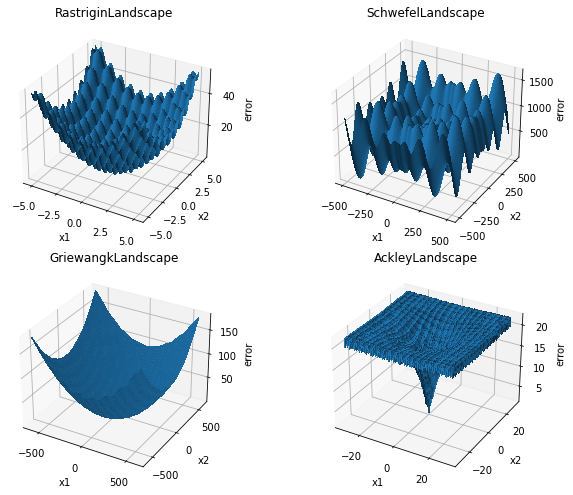

In [24]:
def plotLandscape(ax, landscape, res=200):
    
    minX, maxX = landscape.getInterval()

    X = np.linspace(minX, maxX, res)
    Y = np.linspace(minX, maxX, res)
    
    X, Y = np.meshgrid(X,Y)
    Z = np.zeros((len(X),len(Y)))

    for x in range(len(X)):
        for y in range(len(Y)):
            Z[x,y] = landscape.getError([X[x,y],Y[x,y]])
            
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('error')

    surface = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, antialiased = False)
    ax.set_title(type(landscape).__name__)
    return surface

fig = plt.figure(figsize=(10,7))
axs = [fig.add_subplot(2, 2, i + 1, projection='3d') for i in range(4)]

landscapes = [
    RastriginLandscape,
    SchwefelLandscape,
    GriewangkLandscape,
    AckleyLandscape
]

for i, Landscape in enumerate(landscapes):
    surface = plotLandscape(axs[i], Landscape())

#fig.colorbar(surface, shrink=0.5, aspect=5)


mpl.rcParams.update({'font.size': 14})
plt.tight_layout()
plt.savefig('diagrams/landscapes.png', dpi=300, facecolor='white', transparent=False)

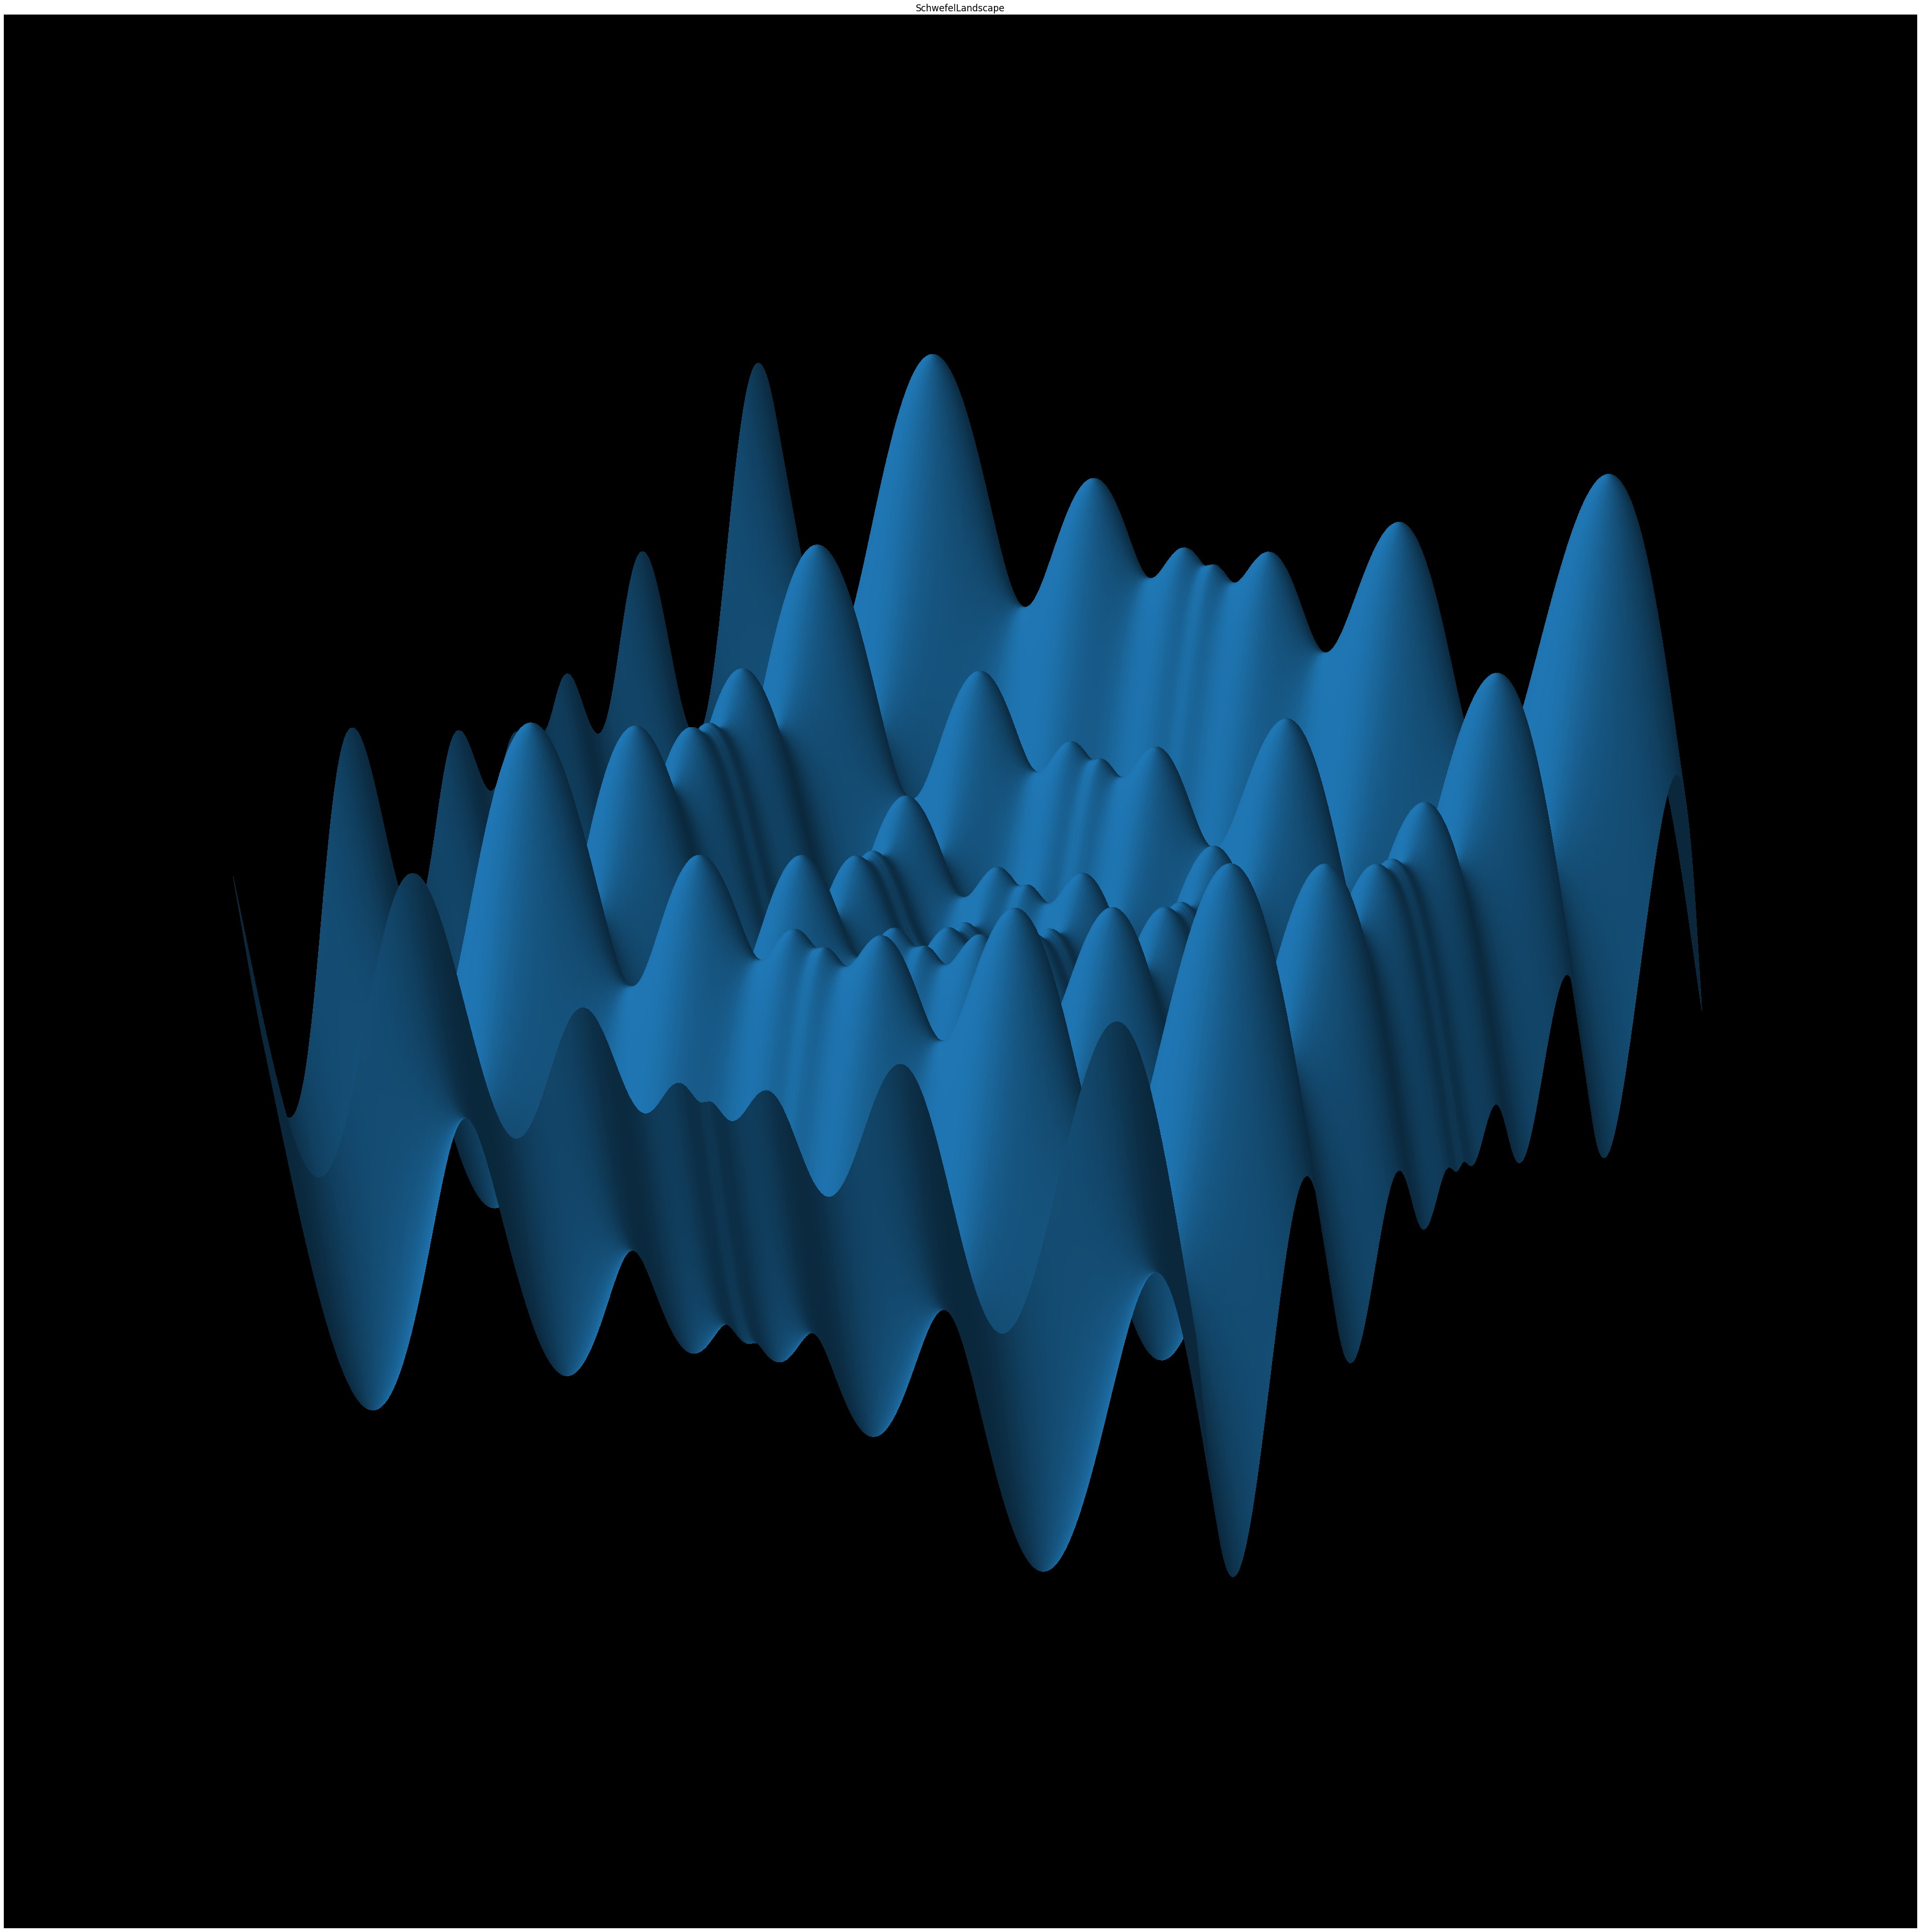

In [25]:
# Render the Schwefel landscape with a black background for my website

fig, ax = plt.subplots(figsize=(50,50))
ax = plt.axes(projection='3d')
ax.set_facecolor("black")
plotLandscape(ax, SchwefelLandscape(), res=500)
ax.axis('off')
plt.tight_layout()
plt.savefig('diagrams/schwefel.png')

# Search Algorithms

In [26]:
class SearchAlgorithm(ABC):
    def __init__(self, errorLandscape, createIndividual):
        self.errorLandscape = errorLandscape
        self.createIndividual = createIndividual
    
    @abstractmethod
    def process(self, maxEvaluations = None):
        """Runs the GA. Should return tuple (bestIndividual, [evaluationCount: lowestError])"""
        pass

## Standard GA

In [27]:
class StandardGA(SearchAlgorithm):
    def process(self, popsize = 100, maxEvaluations = None, debugOutput=False):
        pop = Population(self.createIndividual, popsize=popsize)
        
        highestError = -math.inf
        lowestError = math.inf
        
        for individual in pop.individuals:
            individual.setError(self.errorLandscape.getError(individual.values))
            highestError = max(highestError, individual.getError())
            lowestError = min(lowestError, individual.getError())
        
        bestIndividual = pop.getBestIndividual()
        stats = [(self.errorLandscape.evaluationCount, lowestError, highestError)]
        
        while not (
            bestIndividual.getError() == self.errorLandscape.getLowestError() or
            (maxEvaluations and maxEvaluations < self.errorLandscape.evaluationCount)
        ):
            scaling = stats[0][2] if len(stats) < 5 else stats[-5][2]
            
            pop = pop.createNewGeneration(
                pop,
                self.createIndividual,
                scaling,
                size = popsize
            )
            
            for individual in pop.individuals:
                error = self.errorLandscape.getError(individual.values)
                individual.setError(error)
                
                if error > highestError:
                    highestError = error
                if error < lowestError:
                    lowestError = error
                    bestIndividual = individual

            if maxEvaluations and debugOutput:
                progress = 100 * self.errorLandscape.evaluationCount / maxEvaluations
                if progress % 5 == 0:
                    print('%d percent' % progress)
            stats += [(self.errorLandscape.evaluationCount, lowestError, highestError)]

        return bestIndividual, stats

## CCGA1

In [28]:
class CCGA1(SearchAlgorithm):
    def process(self, popsize = 100, maxEvaluations = None, debugOutput=False):
        pops = [
            Population(self.createIndividual, popsize=popsize)
            for p in range(self.errorLandscape.getN())
        ]
        
        # evaluate error for each individual with random selection from the other pops
        bestIndividuals, lowestError, highestError = self.calculateCooperativeError(pops, None)
        stats = [(self.errorLandscape.evaluationCount, lowestError, highestError)]
        
        while not (
            lowestError == self.errorLandscape.getLowestError() or
            (maxEvaluations and maxEvaluations < self.errorLandscape.evaluationCount)
        ):
            previousPops = [pop.clone() for pop in pops]
            scaling = stats[0][2] if len(stats) < 5 else stats[-5][2]
            
            pops = []

            for previousPop in previousPops:
                pop = previousPop.createNewGeneration(
                    previousPop,
                    self.createIndividual,
                    scaling,
                    size=popsize
                )
                pops += [pop]

            bestIndividuals, lowestError, highestError = self.calculateCooperativeError(pops, previousPops)
            #lowestError = self.errorLandscape.getError([indiv.values[0] for indiv in bestIndividuals])
            
            if maxEvaluations and debugOutput:
                progress = 100 * self.errorLandscape.evaluationCount / maxEvaluations
                if progress % 5 == 0:
                    print('%d percent' % progress)
            
            stats += [(self.errorLandscape.evaluationCount, lowestError, highestError)]
        return bestIndividuals, stats
    
    def calculateCooperativeError(self, pops, previousPops):
        """
            Calculates the cooperative error for every individual with either random or error based selection.
            Returns a list with the most fit individual for each population
        """
        bestIndividuals = []
        
        lowestError = np.inf
        highestError = -np.inf
        
        # implementation note: if randomSelection = true, then we fix the random individuals for each function call
        # so that every individual from pop 1 will be compared against the same individuals from the other pops
        if previousPops:
            compareIndividuals = {popIndex: pop.getBestIndividual() for popIndex, pop in enumerate(previousPops)}
        else:
            compareIndividuals = {popIndex: pop.uniformRandomSelection() for popIndex, pop in enumerate(pops)}
            

        for popIndex, pop in enumerate(pops):
            bestIndividuals += [pop.individuals[0]]
            
            for individual in pop.individuals:
                # create a list of cooperative individuals consisting of our current individual and compareIndividuals
                cooperativeIndividuals = [
                    compareIndividuals[otherPopIndex] if otherPopIndex != popIndex else individual
                    for otherPopIndex in range(len(pops))
                ]
        
                # aggregate their values so that we can feed them to the error landscape
                cooperativeValues = [individual.values[0] for individual in cooperativeIndividuals]
                cooperativeError = self.errorLandscape.getError(cooperativeValues)
                
                # set their cooperative error to the individual
                individual.setError(cooperativeError)
                
                # remember the lowest and highest error for this generation
                lowestError = min(lowestError, cooperativeError)
                highestError = max(highestError, cooperativeError)
                
                if individual.getError() < bestIndividuals[popIndex].getError():
                    bestIndividuals[popIndex] = individual
        
        return bestIndividuals, lowestError, highestError

## ModularGA

In [29]:
class ModularGA(SearchAlgorithm):
    def process(self, popsize = 100, maxEvaluations = None, debugOutput=False):
        pop = Population(self.createIndividual, popsize=popsize - 1)
        
        highestError = -math.inf
        lowestError = math.inf
        
        for individual in pop.individuals:
            individual.setError(self.errorLandscape.getError(individual.values))
            highestError = max(highestError, individual.getError())
            lowestError = min(lowestError, individual.getError())
        
        bestIndividual = pop.getBestIndividual()
        
        # add a combined individual, evaluate it against the best one
        pop.individuals += [self.createCombinedIndividual(bestIndividual, pop, highestError)]
        
        stats = [(self.errorLandscape.evaluationCount, lowestError, highestError)]
        
        while not (
            bestIndividual.getError() == self.errorLandscape.getLowestError() or
            (maxEvaluations and maxEvaluations < self.errorLandscape.evaluationCount)
        ):            
            scaling = stats[0][2] if len(stats) < 5 else stats[-5][2]

            newPop = pop.createNewGeneration(
                pop,
                self.createIndividual,
                scaling,
                size = popsize - 1,
                mutationChance = 1/16
            )
            
            # add a combined individual
            newPop.individuals += [self.createCombinedIndividual(bestIndividual, pop, scaling)]
            
            # throw old population away
            pop = newPop
                        
            highestError = -math.inf
            lowestError = math.inf
            
            for individual in pop.individuals:
                error = self.errorLandscape.getError(individual.values)
                individual.setError(error)
                
                if error > highestError:
                    highestError = error
                if error < lowestError:
                    lowestError = error
                    bestIndividual = individual

            if maxEvaluations and debugOutput:
                progress = 100 * self.errorLandscape.evaluationCount / maxEvaluations
                if progress % 5 == 0:
                    print('%d percent' % progress)

            stats += [(self.errorLandscape.evaluationCount, lowestError, highestError)]

        return bestIndividual, stats
    
    
        while len(found) < size:
            individual = oldGeneration.rouletteSelection(errorScaling)
            crossOverProbability = .6
            if random.random() <= crossOverProbability:
                # crossing over with another random individual
                otherIndividual = individual
                while otherIndividual == individual:
                    #otherIndividual = oldGeneration.uniformRandomSelection()
                    # OR:
                    otherIndividual = oldGeneration.rouletteSelection(errorScaling)
                individual = individual.createFromTwoPointCrossOver(individual, otherIndividual)
            
            '''
            if scramble:
                otherIndividual = oldGeneration.rouletteSelection(errorScaling)
                individual = individual.createFromScrambling(individual, otherIndividual)
            '''
            
            individual = individual.createFromMutation(individual, individual = individual.createFromMutation(individual, 1 / (len(individual.genes) * len(individual.genes[0]))))
            found += [individual.clone()]
    
    def createCombinedIndividual(self, compareIndividual, pop, scaling):
        # evaluate the genes from the best individuals against the compare individual
        parents = [pop.rouletteSelection(scaling) for i in range(self.errorLandscape.getN())]
        #parents = pop.getBestIndividuals(self.errorLandscape.getN())

        # find a good gene from our parents
        bestErrorAndGenes = [(math.inf, bestGenes) for bestGenes in compareIndividual.genes]
        for geneIndex in range(len(compareIndividual.genes)):
            for p in parents:
                values = [p.values[i] if i == geneIndex else compareIndividual.values[i] for i in range(len(compareIndividual.genes))]
                error = self.errorLandscape.getError(values)
                if error < bestErrorAndGenes[geneIndex][0]:
                    bestErrorAndGenes[geneIndex] = (error, p.genes[geneIndex])
        bestGenes = [i[1] for i in bestErrorAndGenes]
            
        # create this new individual and evaluate its final score
        individual = self.createIndividual(bestGenes)
        individual.setError(self.errorLandscape.getError(individual.values))
        return individual

# Plotting Helpers

In [30]:
def runAlgorithm(runs, Algorithm, Landscape, maxEvaluations, showSubsteps):
    algorithmStats = []

    for run in range(runs):
        #print('%.2f percent done on %s' % (100 * run / runs, Algorithm.__name__))
        landscape = Landscape()
        numberOfGenes = 1 if Algorithm == CCGA1 else landscape.getN()

        algorithm = Algorithm(
            landscape,
            lambda genes = None: BitstringIndividual(
                numberOfGenes = numberOfGenes,
                interval=landscape.getInterval(),
                genes=genes
            )
        )
        bestIndividual, currentStats = algorithm.process(
            maxEvaluations = maxEvaluations,
            debugOutput = showSubsteps
        )
        algorithmStats += [currentStats]
    
    return algorithmStats

In [31]:
def plotAlgorithms(runs, Landscape, ylim = None, maxEvaluations=100000, showSubsteps = False, algorithms = None, ax = None, legend=True):
    '''Calculates graph coordinates with all 4 algorithms on one landscape'''
    algorithms = [
        StandardGA,
        CCGA1,
        ModularGA,
    ] if not algorithms else algorithms
    
    ax = ax if ax else plt.subplots()[1]
    
    allAlgorithms = []
    curves = []

    for Algorithm in algorithms:
        algorithmStats = runAlgorithm(runs, Algorithm, Landscape, maxEvaluations, showSubsteps)
            
        # average runs
        longestRunIndex = np.argmax([len(stat) for stat in algorithmStats])
        lowestError = Landscape().getLowestError()
        X = [stat[0] for stat in algorithmStats[longestRunIndex]]
        Y = [0 for i in X]

        for runIndex, run in enumerate(algorithmStats):
            currentY = [run[i][1] for i in range(len(run))] + [lowestError for i in range(len(run), len(X))]
            Y = [Y[i] + currentY[i] for i in range(len(X))]
        
        Y = [y / runs for y in Y]
        
        curves += [ax.plot(X, Y, label=Algorithm.__name__)[0]]
        
        # And sum them up
        allAlgorithms += [(SearchAlgorithm.__name__, Landscape.__name__, X, Y, runs)]

    ax.set_ylim(0, ylim)
    ax.set_xlim(0, max([algorithm[2][-1] for algorithm in allAlgorithms]))
    ax.set_title(Landscape.__name__)
    ax.set_xlabel('function evaluations')
    ax.set_ylabel('best individual error')
    if ylim:
        ax.set_yticks(np.linspace(0, ylim, 5))
    
    if legend:
        ax.legend()
    
    return curves

In [32]:
def plotLandscapes(runs, algorithms=None, ylims=None, oneLegend = False):

    landscapesAndYlims = [
        (RastriginLandscape, 40),
        (SchwefelLandscape, 400),
        (GriewangkLandscape, 8),
        (AckleyLandscape, 16)
    ] if ylims is None else ylims
    
    ylims = [i[1] for i in landscapesAndYlims]
    
    figsize = (9,7) if not oneLegend else (9,8)
    fig, axs = plt.subplots(2,2, figsize=figsize)
    axs = axs.reshape(-1)
    
    for i, Landscape in enumerate([i[0] for i in landscapesAndYlims]):
#         print('==%.2f percent done on %s==' % (100 * i / len(landscapesAndYlims), Landscape.__name__))
        ylim = ylims[i]
        curves = plotAlgorithms(runs, Landscape, ylim=ylim, algorithms=algorithms, ax = axs[i], legend = not oneLegend)
    
    plt.tight_layout()

    if oneLegend:
        print(curves)
        fig.legend(curves, [Algorithm.__name__ for Algorithm in algorithms], loc = 'lower center', ncol=1, labelspacing=0.2)
        plt.tight_layout()
        fig.subplots_adjust(bottom=.25)


    if algorithms == None:
        saveTo = 'diagrams/all_%d_runs' % runs
    else:
        saveTo = "diagrams/%s_%d_runs" %(
            ','.join([Algorithm.__name__ for Algorithm in algorithms]),
            runs
        )
    
    try:
        plt.savefig(saveTo + '.png')
        plt.savefig(saveTo + '.pdf')
        plt.savefig(saveTo + '.svg')
    except:
        print("Export for %s failed" % saveTo)

# Plotting the landscapes

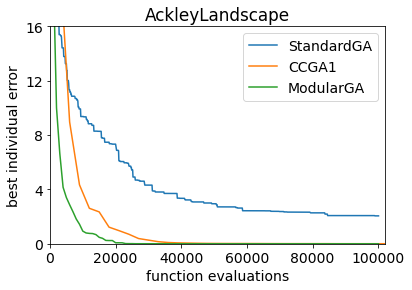

In [33]:
plotAlgorithms(1, AckleyLandscape, algorithms=[StandardGA, CCGA1, ModularGA], ylim=16);

[<matplotlib.lines.Line2D object at 0x180cf1780>, <matplotlib.lines.Line2D object at 0x180cf1ba8>, <matplotlib.lines.Line2D object at 0x181122a90>]


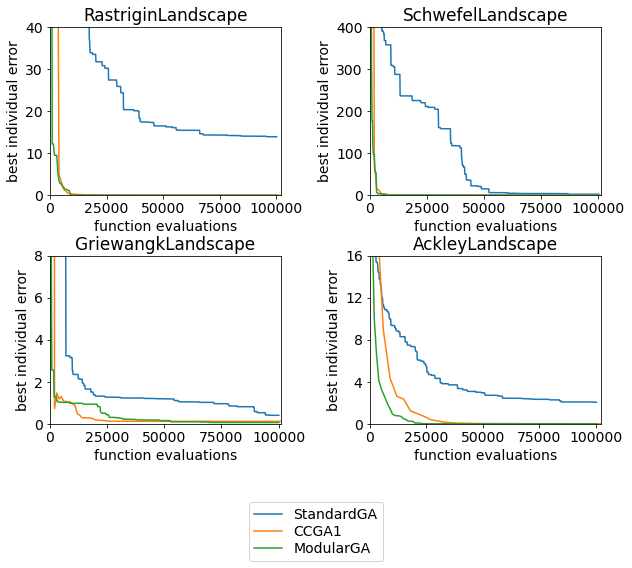

In [34]:
plotLandscapes(1, [StandardGA, CCGA1, ModularGA], oneLegend=True)

[<matplotlib.lines.Line2D object at 0x1817b31d0>, <matplotlib.lines.Line2D object at 0x1817b3358>, <matplotlib.lines.Line2D object at 0x17fe65630>]


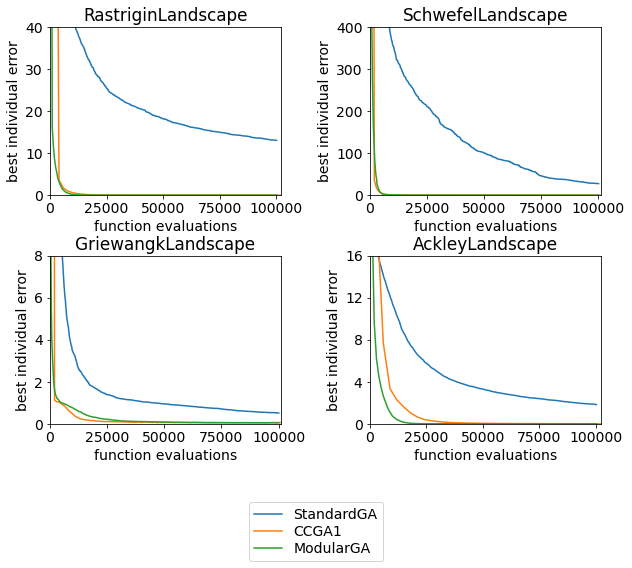

In [35]:
plotLandscapes(50, [StandardGA, CCGA1, ModularGA], oneLegend=True)

In [36]:
# plotLandscapes(50, [StandardGA, CCGA1, ModularGA, oneLegend=True)